# Heart Failure

The following example is a binary classification domain adaptation issue based on the heart failure UCI dataset:

https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records

The goal is to predict the survival of patients with heart failure (binary). Two domains are defined by splitting the dataset along the "sex" binary variable.


In [15]:
import os

import adapt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise, BatchNormalization
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.regularizers import l2

from adapt.feature_based import DANN, ADDA, DeepCORAL, CORAL, MCD, MDD, WDGRL, CDAN

## Setup

In [16]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv")
df.head(3)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1


In [17]:
Xs = df.loc[df["sex"] == 0].drop(["DEATH_EVENT"], axis=1).drop(["sex", "creatinine_phosphokinase"], axis=1).values
ys = df.loc[df["sex"] == 0, "DEATH_EVENT"].values
Xt = df.loc[df["sex"] == 1].drop(["DEATH_EVENT"], axis=1).drop(["sex", "creatinine_phosphokinase"], axis=1).values
yt = df.loc[df["sex"] == 1, "DEATH_EVENT"].values

std_sc = StandardScaler().fit(np.concatenate((Xs, Xt)))
Xs = std_sc.transform(Xs)
Xt = std_sc.transform(Xt)

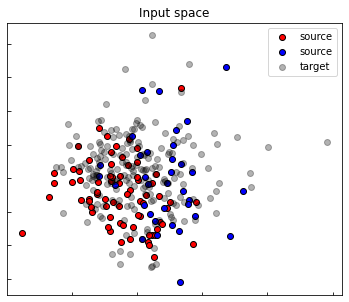

In [18]:
pca = PCA(2).fit(np.concatenate((Xs, Xt)))
Xs_pca = pca.transform(Xs)
Xt_pca = pca.transform(Xt)

x_min, y_min = np.min([Xs_pca.min(0), Xt_pca.min(0)], 0)
x_max, y_max = np.max([Xs_pca.max(0), Xt_pca.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = pca.inverse_transform(np.stack([x_grid.ravel(), y_grid.ravel()], -1))

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Input space")
ax1.scatter(Xs_pca[ys==0, 0], Xs_pca[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs_pca[ys==1, 0], Xs_pca[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt_pca[:, 0], Xt_pca[:, 1], label="target", edgecolors='k', c="black", alpha=0.3)
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.show()

In [19]:
def show_results(model, is_src_only=False):
    ys_pred = model.predict(Xs)
    yt_pred = model.predict(Xt)
    acc_s = accuracy_score(ys, ys_pred>0.5)
    acc_t = accuracy_score(yt, yt_pred>0.5)

    yp_grid = model.predict(X_grid).reshape(100, 100)

    Xs_enc = model.transform(Xs)
    Xt_enc = model.transform(Xt)
    pca_enc = PCA(2).fit(np.concatenate((Xs_enc, Xt_enc)))
    Xs_enc_pca = pca_enc.transform(Xs_enc)
    Xt_enc_pca = pca_enc.transform(Xt_enc)

    cm = plt.cm.RdBu
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.set_title("PCA input space")
    ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
    ax1.scatter(Xs_pca[ys==0, 0], Xs_pca[ys==0, 1], label="source", edgecolors='k', c="red")
    ax1.scatter(Xs_pca[ys==1, 0], Xs_pca[ys==1, 1], label="source", edgecolors='k', c="blue")
    ax1.scatter(Xt_pca[:, 0], Xt_pca[:, 1], label="target", edgecolors='k', c="black", alpha=0.5)
    ax1.legend()
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.tick_params(direction ='in')

    ax2.set_title("PCA encoded space")
    ax2.scatter(Xs_enc_pca[ys==0, 0], Xs_enc_pca[ys==0, 1], label="source", edgecolors='k', c="red")
    ax2.scatter(Xs_enc_pca[ys==1, 0], Xs_enc_pca[ys==1, 1], label="source", edgecolors='k', c="blue")
    ax2.scatter(Xt_enc_pca[:, 0], Xt_enc_pca[:, 1], label="target", edgecolors='k', c="black", alpha=0.5)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.tick_params(direction ='in')
    if is_src_only:
        fig.suptitle("%s - Source Acc : %.3f - Target Acc : %.3f"%("Source Only", acc_s, acc_t))
    else:
        fig.suptitle("%s - Source Acc : %.3f - Target Acc : %.3f"%(model.__class__.__name__, acc_s, acc_t))
    plt.show()

## Network

In [20]:
def get_task(activation="sigmoid", units=1):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(10, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(units, activation=activation))
    return model

## Source Only

For source only, we use a DANN instance with lambda set to zero. Thus, the gradient of the discriminator is not back-propagated through the encoder.

In [21]:
src_only = DANN(task=get_task(),
                loss="bce", optimizer=Adam(0.001, beta_1=0.5),
                copy=True, lambda_=0., metrics=["acc"], random_state=0)

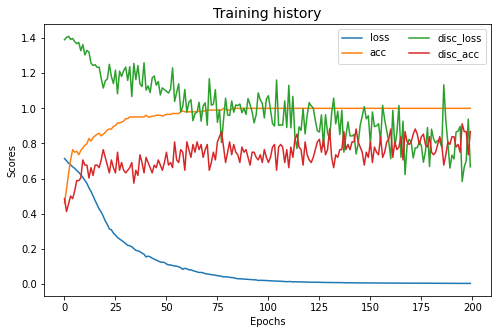

In [22]:
src_only.fit(Xs, ys, Xt, epochs=200, batch_size=34, verbose=0);
pd.DataFrame(src_only.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

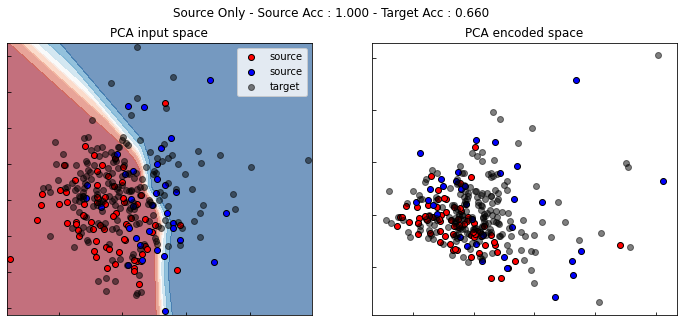

In [23]:
show_results(src_only, True)

## [DANN](https://adapt-python.github.io/adapt/generated/adapt.feature_based.DANN.html)

In [24]:
dann = DANN(task=get_task(), loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, lambda_=1., metrics=["acc"], random_state=0)

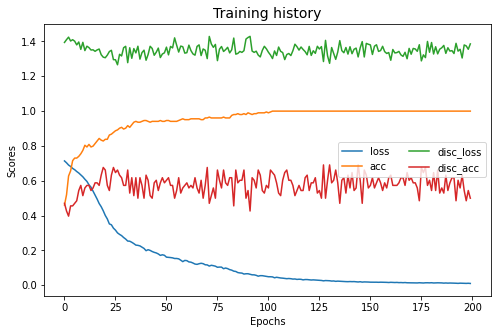

In [25]:
dann.fit(Xs, ys, Xt, epochs=200, batch_size=34, verbose=0);
pd.DataFrame(dann.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

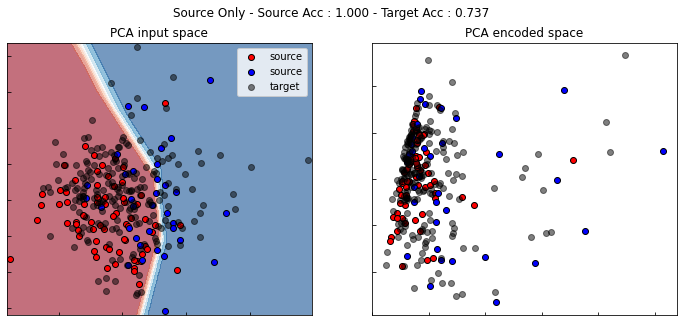

In [26]:
show_results(dann, True)

## [ADDA](https://adapt-python.github.io/adapt/generated/adapt.feature_based.ADDA.html)

In [ ]:
adda = ADDA(task=get_task(),
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

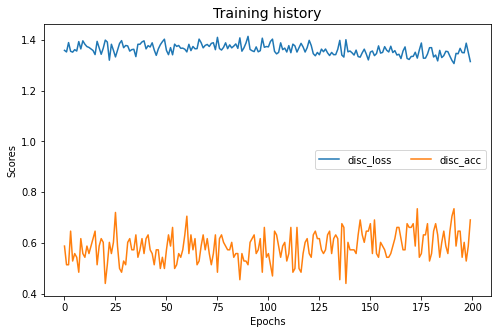

In [ ]:
adda.fit(Xs, ys, Xt, epochs=200, batch_size=34, verbose=0);
pd.DataFrame(adda.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

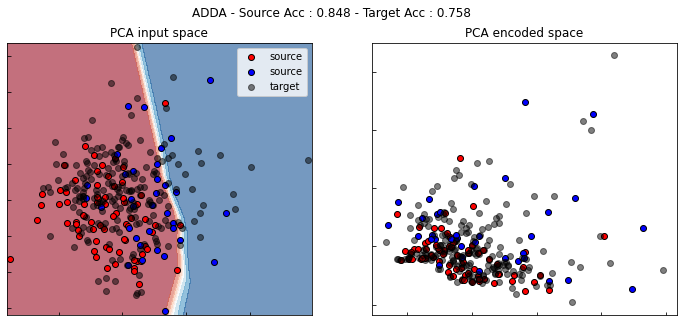

In [ ]:
show_results(adda)

## [DeepCORAL](https://adapt-python.github.io/adapt/generated/adapt.feature_based.DeepCORAL.html)

In [ ]:
dcoral = DeepCORAL(encoder=src_only.encoder_, 
                   task=src_only.task_, lambda_=1000.,
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

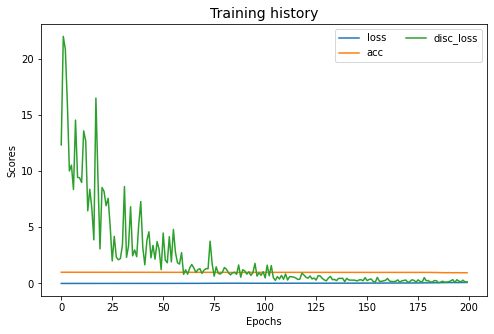

In [ ]:
dcoral.fit(Xs, ys, Xt, epochs=200, batch_size=34, verbose=0);
pd.DataFrame(dcoral.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

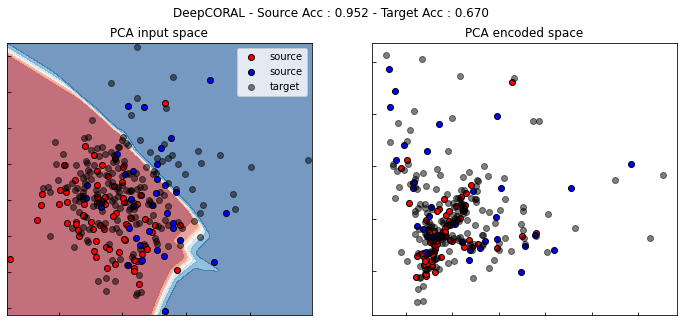

In [ ]:
show_results(dcoral)

## [CORAL](https://adapt-python.github.io/adapt/generated/adapt.feature_based.CORAL.html)

In [ ]:
coral = CORAL(estimator=get_task(), lambda_=0.,
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

Fit transform...
Previous covariance difference: 0.106929
New covariance difference: 0.000000
Fit Estimator...


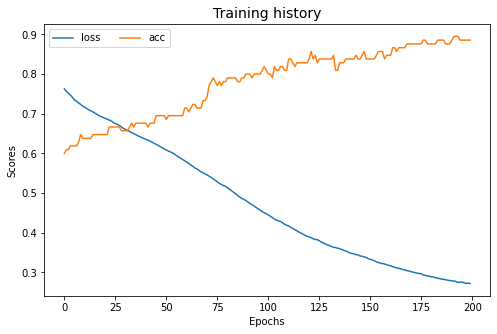

In [ ]:
coral.fit(Xs, ys, Xt, epochs=200, batch_size=34, verbose=0);
pd.DataFrame(coral.estimator_.history.history).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

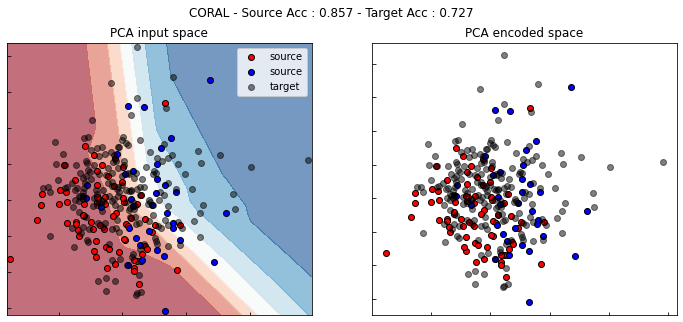

In [ ]:
show_results(coral)

## [MCD](https://adapt-python.github.io/adapt/generated/adapt.feature_based.MCD.html)

In [ ]:
mcd = MCD(task=get_task(),
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

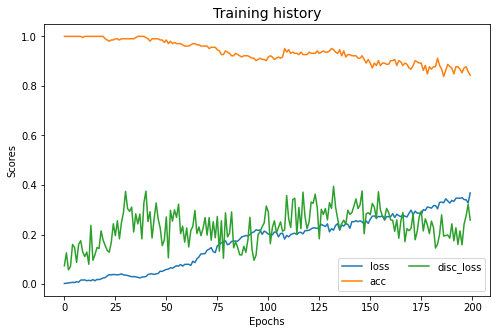

In [ ]:
mcd.fit(Xs, ys, Xt, epochs=200, batch_size=34, verbose=0);
pd.DataFrame(mcd.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

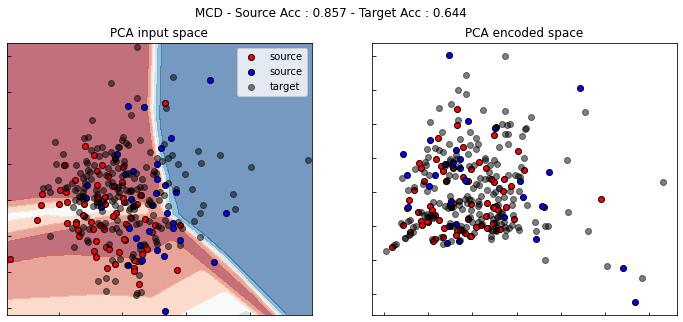

In [ ]:
show_results(mcd)

## [MDD](https://adapt-python.github.io/adapt/generated/adapt.feature_based.MDD.html)

In [ ]:
mdd = MDD(task=get_task(),
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

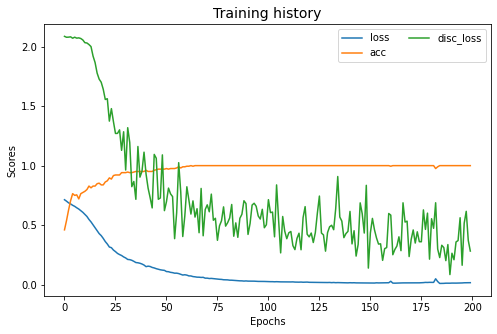

In [ ]:
mdd.fit(Xs, ys, Xt, epochs=200, batch_size=34, verbose=0);
pd.DataFrame(mdd.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

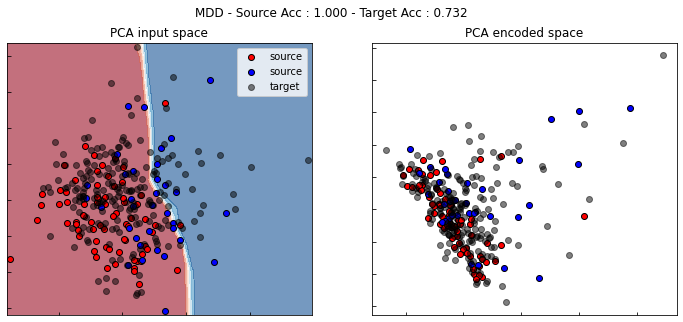

In [ ]:
show_results(mdd)

## [WDGRL](https://adapt-python.github.io/adapt/generated/adapt.feature_based.WDGRL.html)

In [ ]:
wdgrl = WDGRL(task=get_task(None), gamma=0.,
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

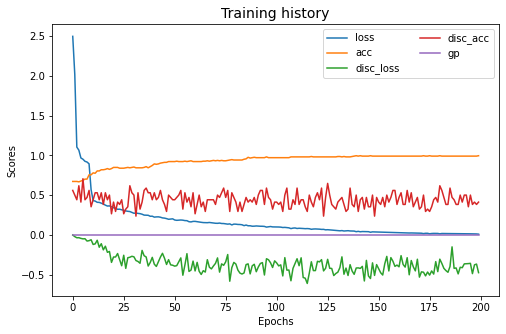

In [ ]:
wdgrl.fit(Xs, ys, Xt, epochs=200, batch_size=34, verbose=0);
pd.DataFrame(wdgrl.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

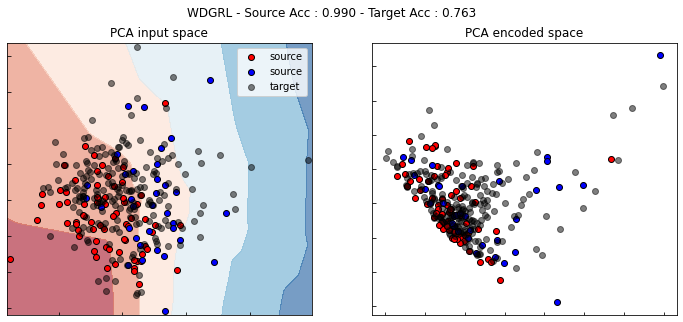

In [ ]:
show_results(wdgrl)

## [CDAN](https://adapt-python.github.io/adapt/generated/adapt.feature_based.CDAN.html)

In [ ]:
cdan = CDAN(task=get_task(), entropy=True,
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, random_state=0) 

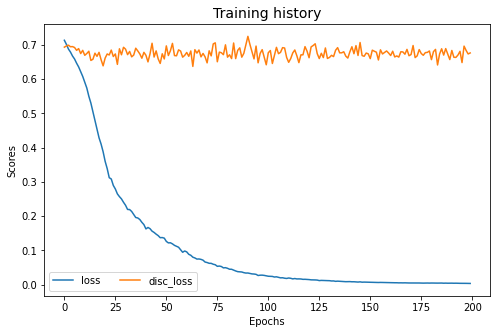

In [ ]:
cdan.fit(Xs, ys, Xt, epochs=200, batch_size=34, verbose=0);
pd.DataFrame(cdan.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

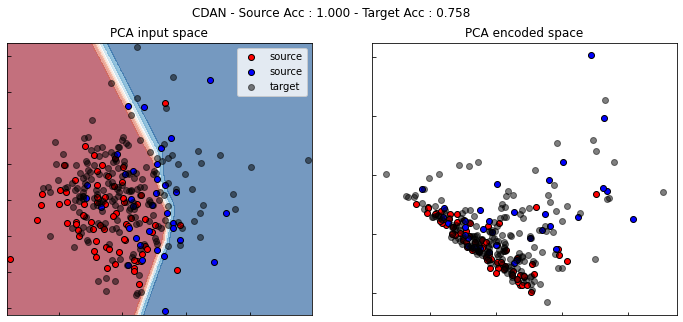

In [ ]:
show_results(cdan)